Initializing libraries

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
from xgboost import XGBClassifier

Loading datasets

In [131]:
df = pd.read_csv("kepler1.csv", comment='#')


Data Processing

In [53]:
print(df.columns.tolist())


['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag']


In [74]:
base_features = [
    # --- Orbital characteristics ---
    'koi_period',        # Orbital period (days)
    'koi_time0bk',       # Transit epoch (start time)
    'koi_duration',      # Transit duration (hours)
    'koi_depth',         # Transit depth (ppm)
    'koi_impact',        # Impact parameter

    # --- Planetary characteristics ---
    'koi_prad',          # Planetary radius (Earth radii)
    'koi_teq',           # Equilibrium temperature (K)
    'koi_insol',         # Insolation flux (Earth flux)

    # --- Stellar characteristics ---
    'koi_steff',         # Stellar effective temperature (K)
    'koi_slogg',         # Stellar surface gravity (log10(cm/s²))
    'koi_srad',          # Stellar radius (Solar radii)

    # --- Observation / signal quality ---
    'koi_model_snr',     # Transit signal-to-noise
    'koi_kepmag',        # Kepler-band magnitude (brightness)
    'ra',                # Right ascension
    'dec'                # Declination
]

In [110]:
df["planet_star_radius_ratio"] = df["koi_prad"] / df["koi_srad"]
df["insolation_temp_ratio"] = df["koi_insol"] / df["koi_teq"]
df["log_period"] = np.log1p(df["koi_period"])
df["log_snr"] = np.log1p(df["koi_model_snr"])
df["depth_duration_ratio"] = df["koi_depth"] / df["koi_duration"]

features = base_features + [
    "planet_star_radius_ratio",
    "insolation_temp_ratio",
    "log_period",
    "log_snr",
    "depth_duration_ratio"
]


In [111]:
target = "koi_disposition"

df = df[features + [target]].dropna()

X = df[features]
y = df[target]

X = X.fillna(X.median(numeric_only=True))


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y = le.fit_transform(y)


print("Classes:", le.classes_)

Classes: ['CANDIDATE' 'CONFIRMED' 'FALSE POSITIVE']


Train/Test Split

In [112]:
X_train, X_test, y_train, y_test = train_test_split(
X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

Training Model

In [134]:
model = XGBClassifier(subsample=1, reg_lambda=1, n_estimators=500, min_child_weight=1, max_depth=6, learning_rate=0.01, gamma=0, colsample_bytree=0.9)
model.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


Evaluation

Accuracy: 0.7907608695652174

Classification Report:
                 precision    recall  f1-score   support

     CANDIDATE       0.60      0.57      0.59       375
     CONFIRMED       0.83      0.87      0.85       549
FALSE POSITIVE       0.84      0.83      0.84       916

      accuracy                           0.79      1840
     macro avg       0.76      0.76      0.76      1840
  weighted avg       0.79      0.79      0.79      1840



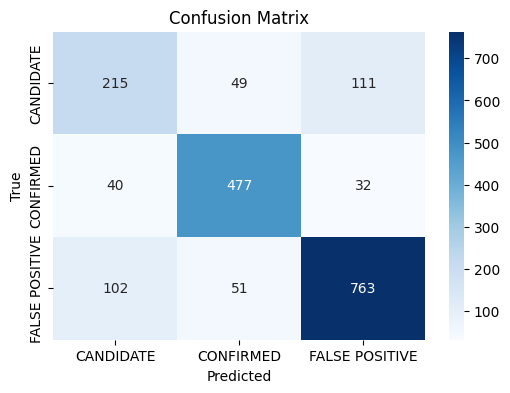

In [135]:
y_pred = model.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Saving Model

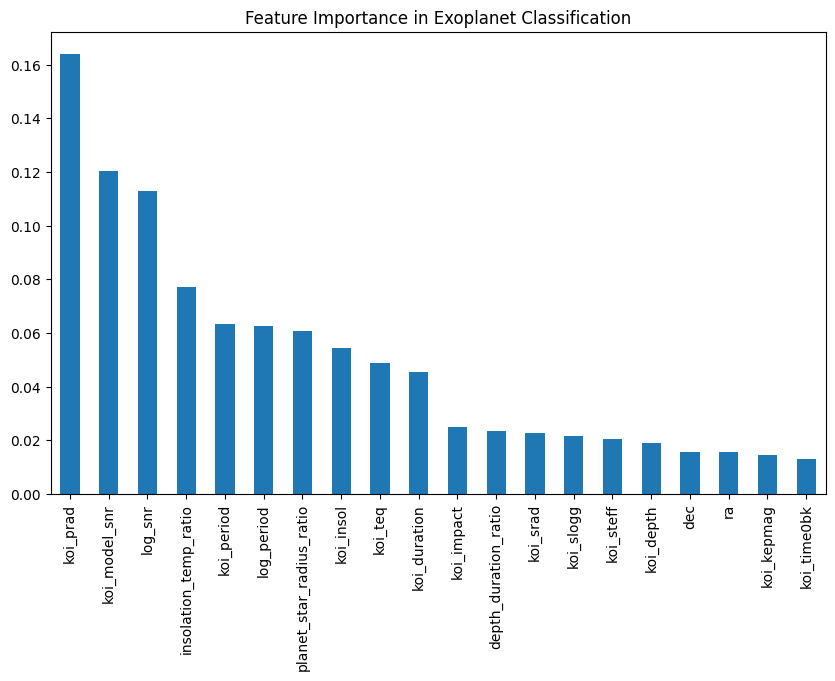

In [136]:
feat_importance = pd.Series(model.feature_importances_, index=X.columns)
feat_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10,6))
plt.title("Feature Importance in Exoplanet Classification")
plt.show()

In [ ]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)